In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import userdata
PAT = userdata.get('PAT')

In [ ]:
!git clone https://$PAT@github.com/Pmoonesi/AD_Prediction_wangyirui.git

Cloning into 'AD_Prediction_wangyirui'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (594/594), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 594 (delta 359), reused 594 (delta 359), pack-reused 0
Receiving objects: 100% (594/594), 5.70 MiB | 33.75 MiB/s, done.
Resolving deltas: 100% (359/359), done.


In [2]:
!rm -rf sample_data

In [3]:
!ls /content/drive/MyDrive/Data/wangyirui/preprocessed/ADNI/ | grep data_backup | tail -n 5 | while read f; do cp /content/drive/MyDrive/Data/wangyirui/preprocessed/ADNI/$f .; done

In [4]:
!mkdir ADNI

In [5]:
!ls . | grep data_backup | while read f; do tar -xf $f -C ADNI; rm $f; done;

In [ ]:
# !rm data_backup*

In [6]:
!cp /content/drive/MyDrive/Data/wangyirui/preprocessed/subject_group.txt .

In [7]:
import nibabel as nib

In [8]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [9]:
def load_image_and_labels():
  import glob, re
  images = sorted(glob.glob('ADNI/**/*.nii', recursive=True))
  patients = dict(line.strip().split(' ') for line in open('data_group.txt'))

  labels = []
  for image in images:
    subject_id = re.findall("ADNI/(\d{3}_S_\d{4})", image)[0]

    if subject_id not in patients:
      print('shit')
      break

    labels.append(patients[subject_id])

  assert len(images) == len(labels)

  return images, labels

In [10]:
images, labels = load_image_and_labels()

In [ ]:
corrupted = check_files(images)

In [ ]:
print(corrupted)

In [11]:
index = images.index('ADNI/041_S_1425/MPR__GradWarp__B1_Correction__N3__Scaled/2008-08-07_13_04_18.0/I121404/ADNI_041_S_1425_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081016155426582_S55125_I121404.nii')
images.pop(index)
labels.pop(index)

'MCI'

In [12]:
from sklearn.model_selection import train_test_split

In [ ]:
train_files, test_files, train_labels, test_labels = train_test_split(images , labels,
                                   random_state=104,
                                   test_size=0.15,
                                   shuffle=True)

In [ ]:
# import os
# from collections import Counter
# import re
# disease = Counter()
# classes = {}

# with open('subject_group.txt', 'r') as labels:
#   for label in labels.readlines():
#     subject_id, subject_condition = label.strip().split(' ')
#     classes[subject_id] = subject_condition
#     disease[subject_condition] += 1

# with open('train_classes.txt', 'w') as f_train:
#   for train_file in train_files:
#     subject_id = re.findall("ADNI/(\d{3}_S_\d{4})", train_file)[0]
#     if subject_id in classes:
#       f_train.write(f"{train_file}\t{classes[subject_id]}\n")
#     else:
#       print(f'fault in {train_file}')
#       continue

# with open('test_classes.txt', 'w') as f_test:
#   for test_file in test_files:
#     subject_id = re.findall("ADNI/(\d{3}_S_\d{4})", test_file)[0]
#     if subject_id in classes:
#       f_test.write(f"{test_file}\t{classes[subject_id]}\n")
#     else:
#       print(f'fault in {test_file}')
#       continue


## Tensorflow (failed)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, BatchNormalization

# Define the 3D CNN model
model = Sequential()

# Convolutional layers
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(192, 192, 160, 1)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer and fully connected layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))  # 3 classes: 'AD', 'MCI', 'Normal'

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 190, 190, 158, 3   896       
                             2)                                  
                                                                 
 batch_normalization (Batch  (None, 190, 190, 158, 3   128       
 Normalization)              2)                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 95, 95, 79, 32)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 93, 93, 77, 64)    55360     
                                                                 
 batch_normalization_1 (Bat  (None, 93, 93, 77, 64)    256       
 chNormalization)                                       

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'X' is a list of file paths to your images and 'y' is your labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)

# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

# Create a tf.data.Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))

# Create a tf.data.Dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))


# Function to preprocess each image
def preprocess_nifti(file_path, label):
    # Load NIfTI image
    nifti_img = nib.load(file_path.numpy().decode('utf-8').strip())

    # Get the image data
    img_data = nifti_img.get_fdata()

    del nifti_img

    # Assuming the data is in a reasonable range, you may normalize it
    img_data = img_data / 6482.063678255918

    # Expand dimensions to add a channel (assuming grayscale images)
    img_data = tf.expand_dims(img_data, axis=-1)

    return img_data, label

def my_tf_function(x, y):
    # Define the shape and data type of the output tensor
    x_shape = tf.TensorShape(x.shape)
    y_shape = tf.TensorShape(y.shape)

    # Apply the Python function using tf.py_function
    result_x, result_y = tf.py_function(preprocess_nifti, [x, y], [tf.float64 ,tf.float32])

    # Reshape the result if necessary
    result_y.set_shape(y_shape)

    return result_x, result_y

# Map the preprocessing function to the datasets
train_dataset = train_dataset.map(lambda x, y: my_tf_function(x, y))
test_dataset = test_dataset.map(lambda x, y: my_tf_function(x, y))

# Batch and shuffle the datasets
batch_size = 16
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
list(iter(train_dataset))[0][0].numpy().shape

(16, 192, 192, 160, 1)

In [ ]:
model.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10


## Pytorch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(128)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 24 * 24 * 20, 64)
        self.batch_norm_fc = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D2(nn.Module):
    def __init__(self):
        super(CNN3D2, self).__init__()

        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 24 * 24 * 20, 64)
        self.batch_norm_fc = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D3(nn.Module):
    def __init__(self):
        super(CNN3D3, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(32)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 24 * 24 * 20, 32)
        self.batch_norm_fc = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D4(nn.Module):
    def __init__(self):
        super(CNN3D4, self).__init__()

        self.conv1 = nn.Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(4)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(8)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(16)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 24 * 24 * 20, 16)
        self.batch_norm_fc = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D5(nn.Module):
    def __init__(self):
        super(CNN3D5, self).__init__()

        self.conv1 = nn.Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(4)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(8)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 48 * 48 * 40, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D6(nn.Module):
    def __init__(self):
        super(CNN3D6, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 24 * 24 * 20, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D7(nn.Module):
    def __init__(self):
        super(CNN3D7, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(8)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(4)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 24 * 24 * 20, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D8(nn.Module):
    def __init__(self):
        super(CNN3D8, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.drop2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv3d(16, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(4)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.drop3 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 24 * 24 * 20, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.drop3(x)

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D9(nn.Module):
    def __init__(self):
        super(CNN3D9, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm4 = nn.BatchNorm3d(4)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 11 * 11 * 13, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D10(nn.Module):
    def __init__(self):
        super(CNN3D10, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(8)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm4 = nn.BatchNorm3d(4)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 12 * 12 * 10, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D11(nn.Module):
    def __init__(self):
        super(CNN3D11, self).__init__()

        self.conv1 = nn.Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(4)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(8)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm4 = nn.BatchNorm3d(4)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 12 * 12 * 10, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

class CNN3D12(nn.Module):
    def __init__(self):
        super(CNN3D12, self).__init__()

        self.conv1 = nn.Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(4)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(8)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(4)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 24 * 24 * 20, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

class CNN3D13(nn.Module):
    def __init__(self):
        super(CNN3D13, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm4 = nn.BatchNorm3d(4)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 12 * 12 * 10, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D14(nn.Module):
    def __init__(self):
        super(CNN3D14, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(16)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm4 = nn.BatchNorm3d(8)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm5 = nn.BatchNorm3d(4)
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 6 * 6 * 5, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))
        x = self.pool5(F.relu(self.batch_norm5(self.conv5(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D15(nn.Module):
    def __init__(self):
        super(CNN3D15, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4 = nn.Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm4 = nn.BatchNorm3d(8)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm5 = nn.BatchNorm3d(4)
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv6 = nn.Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm6 = nn.BatchNorm3d(4)
        self.pool6 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 3 * 3 * 3, 8)
        self.batch_norm_fc = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))
        x = self.pool5(F.relu(self.batch_norm5(self.conv5(x))))
        x = nn.functional.pad(x, (0, 0, 0, 0, 0, 1))
        x = self.pool6(F.relu(self.batch_norm6(self.conv6(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


class CNN3D16(nn.Module):
    def __init__(self):
        super(CNN3D16, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4 = nn.Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm4 = nn.BatchNorm3d(8)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5 = nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm5 = nn.BatchNorm3d(4)
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv6 = nn.Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm6 = nn.BatchNorm3d(4)
        self.pool6 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(4 * 3 * 3 * 3, 8)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch_norm4(self.conv4(x))))
        x = self.pool5(F.relu(self.batch_norm5(self.conv5(x))))
        x = nn.functional.pad(x, (0, 0, 0, 0, 0, 1))
        x = self.pool6(F.relu(self.batch_norm6(self.conv6(x))))

        x = self.flatten(x)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

### compare sizes

In [ ]:
from torchsummary import summary

In [ ]:
model1 = CNN3D().cuda()
summary(model1, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 32, 160, 192, 192]             896
       BatchNorm3d-2    [-1, 32, 160, 192, 192]              64
         MaxPool3d-3       [-1, 32, 80, 96, 96]               0
            Conv3d-4       [-1, 64, 80, 96, 96]          55,360
       BatchNorm3d-5       [-1, 64, 80, 96, 96]             128
         MaxPool3d-6       [-1, 64, 40, 48, 48]               0
            Conv3d-7      [-1, 128, 40, 48, 48]         221,312
       BatchNorm3d-8      [-1, 128, 40, 48, 48]             256
         MaxPool3d-9      [-1, 128, 20, 24, 24]               0
          Flatten-10              [-1, 1474560]               0
           Linear-11                   [-1, 64]      94,371,904
      BatchNorm1d-12                   [-1, 64]             128
           Linear-13                    [-1, 3]             195
Total params: 94,650,243
Trainable para

In [ ]:
model2 = CNN3D2().cuda()
summary(model2, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 160, 192, 192]             448
       BatchNorm3d-2    [-1, 16, 160, 192, 192]              32
         MaxPool3d-3       [-1, 16, 80, 96, 96]               0
            Conv3d-4       [-1, 32, 80, 96, 96]          13,856
       BatchNorm3d-5       [-1, 32, 80, 96, 96]              64
         MaxPool3d-6       [-1, 32, 40, 48, 48]               0
            Conv3d-7       [-1, 64, 40, 48, 48]          55,360
       BatchNorm3d-8       [-1, 64, 40, 48, 48]             128
         MaxPool3d-9       [-1, 64, 20, 24, 24]               0
          Flatten-10               [-1, 737280]               0
           Linear-11                   [-1, 64]      47,185,984
      BatchNorm1d-12                   [-1, 64]             128
           Linear-13                    [-1, 3]             195
Total params: 47,256,195
Trainable para

In [ ]:
model3 = CNN3D3().cuda()
summary(model3, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
            Conv3d-7       [-1, 32, 40, 48, 48]          13,856
       BatchNorm3d-8       [-1, 32, 40, 48, 48]              64
         MaxPool3d-9       [-1, 32, 20, 24, 24]               0
          Flatten-10               [-1, 368640]               0
           Linear-11                   [-1, 32]      11,796,512
      BatchNorm1d-12                   [-1, 32]              64
           Linear-13                    [-1, 3]              99
Total params: 11,814,339
Trainable para

In [ ]:
model6 = CNN3D6().cuda()
summary(model6, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
            Conv3d-7        [-1, 8, 40, 48, 48]           3,464
       BatchNorm3d-8        [-1, 8, 40, 48, 48]              16
         MaxPool3d-9        [-1, 8, 20, 24, 24]               0
          Flatten-10                [-1, 92160]               0
           Linear-11                    [-1, 8]         737,288
      BatchNorm1d-12                    [-1, 8]              16
           Linear-13                    [-1, 3]              27
Total params: 744,555
Trainable params:

In [ ]:
model7 = CNN3D7().cuda()
summary(model7, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4        [-1, 8, 80, 96, 96]           1,736
       BatchNorm3d-5        [-1, 8, 80, 96, 96]              16
         MaxPool3d-6        [-1, 8, 40, 48, 48]               0
            Conv3d-7        [-1, 4, 40, 48, 48]             868
       BatchNorm3d-8        [-1, 4, 40, 48, 48]               8
         MaxPool3d-9        [-1, 4, 20, 24, 24]               0
          Flatten-10                [-1, 46080]               0
           Linear-11                    [-1, 8]         368,648
      BatchNorm1d-12                    [-1, 8]              16
           Linear-13                    [-1, 3]              27
Total params: 371,559
Trainable params:

In [ ]:
model8 = CNN3D8().cuda()
summary(model8, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
           Dropout-7       [-1, 16, 40, 48, 48]               0
            Conv3d-8        [-1, 4, 40, 48, 48]           1,732
       BatchNorm3d-9        [-1, 4, 40, 48, 48]               8
        MaxPool3d-10        [-1, 4, 20, 24, 24]               0
          Dropout-11        [-1, 4, 20, 24, 24]               0
          Flatten-12                [-1, 46080]               0
           Linear-13                    [-1, 8]         368,648
      BatchNorm1d-14                   

In [ ]:
model9 = CNN3D9().cuda()
summary(model9, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
            Conv3d-7        [-1, 8, 40, 48, 48]           3,464
       BatchNorm3d-8        [-1, 8, 40, 48, 48]              16
         MaxPool3d-9        [-1, 8, 20, 24, 24]               0
           Conv3d-10        [-1, 4, 20, 24, 24]             868
      BatchNorm3d-11        [-1, 4, 20, 24, 24]               8
        MaxPool3d-12        [-1, 4, 10, 12, 12]               0
          Flatten-13                 [-1, 5760]               0
           Linear-14                   

In [ ]:
model10 = CNN3D10().cuda()
summary(model10, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4        [-1, 8, 80, 96, 96]           1,736
       BatchNorm3d-5        [-1, 8, 80, 96, 96]              16
         MaxPool3d-6        [-1, 8, 40, 48, 48]               0
            Conv3d-7        [-1, 8, 40, 48, 48]           1,736
       BatchNorm3d-8        [-1, 8, 40, 48, 48]              16
         MaxPool3d-9        [-1, 8, 20, 24, 24]               0
           Conv3d-10        [-1, 4, 20, 24, 24]             868
      BatchNorm3d-11        [-1, 4, 20, 24, 24]               8
        MaxPool3d-12        [-1, 4, 10, 12, 12]               0
          Flatten-13                 [-1, 5760]               0
           Linear-14                   

In [ ]:
model11 = CNN3D11().cuda()
summary(model11, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 4, 160, 192, 192]             112
       BatchNorm3d-2     [-1, 4, 160, 192, 192]               8
         MaxPool3d-3        [-1, 4, 80, 96, 96]               0
            Conv3d-4        [-1, 8, 80, 96, 96]             872
       BatchNorm3d-5        [-1, 8, 80, 96, 96]              16
         MaxPool3d-6        [-1, 8, 40, 48, 48]               0
            Conv3d-7        [-1, 8, 40, 48, 48]           1,736
       BatchNorm3d-8        [-1, 8, 40, 48, 48]              16
         MaxPool3d-9        [-1, 8, 20, 24, 24]               0
           Conv3d-10        [-1, 4, 20, 24, 24]             868
      BatchNorm3d-11        [-1, 4, 20, 24, 24]               8
        MaxPool3d-12        [-1, 4, 10, 12, 12]               0
          Flatten-13                 [-1, 5760]               0
           Linear-14                   

In [ ]:
model12 = CNN3D12().cuda()
summary(model12, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 4, 160, 192, 192]             112
       BatchNorm3d-2     [-1, 4, 160, 192, 192]               8
         MaxPool3d-3        [-1, 4, 80, 96, 96]               0
            Conv3d-4        [-1, 8, 80, 96, 96]             872
       BatchNorm3d-5        [-1, 8, 80, 96, 96]              16
         MaxPool3d-6        [-1, 8, 40, 48, 48]               0
            Conv3d-7        [-1, 4, 40, 48, 48]             868
       BatchNorm3d-8        [-1, 4, 40, 48, 48]               8
         MaxPool3d-9        [-1, 4, 20, 24, 24]               0
          Flatten-10                [-1, 46080]               0
           Linear-11                    [-1, 8]         368,648
      BatchNorm1d-12                    [-1, 8]              16
          Dropout-13                    [-1, 8]               0
           Linear-14                   

In [ ]:
model13 = CNN3D13().cuda()
summary(model13, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
            Conv3d-7        [-1, 8, 40, 48, 48]           3,464
       BatchNorm3d-8        [-1, 8, 40, 48, 48]              16
         MaxPool3d-9        [-1, 8, 20, 24, 24]               0
           Conv3d-10        [-1, 4, 20, 24, 24]             868
      BatchNorm3d-11        [-1, 4, 20, 24, 24]               8
        MaxPool3d-12        [-1, 4, 10, 12, 12]               0
          Flatten-13                 [-1, 5760]               0
           Linear-14                   

In [ ]:
model14 = CNN3D14().cuda()
summary(model14, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
            Conv3d-7       [-1, 16, 40, 48, 48]           6,928
       BatchNorm3d-8       [-1, 16, 40, 48, 48]              32
         MaxPool3d-9       [-1, 16, 20, 24, 24]               0
           Conv3d-10        [-1, 8, 20, 24, 24]           3,464
      BatchNorm3d-11        [-1, 8, 20, 24, 24]              16
        MaxPool3d-12        [-1, 8, 10, 12, 12]               0
           Conv3d-13        [-1, 4, 10, 12, 12]             868
      BatchNorm3d-14        [-1, 4, 10,

In [ ]:
model15 = CNN3D15().cuda()
summary(model15, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
            Conv3d-7        [-1, 8, 40, 48, 48]           3,464
       BatchNorm3d-8        [-1, 8, 40, 48, 48]              16
         MaxPool3d-9        [-1, 8, 20, 24, 24]               0
           Conv3d-10        [-1, 8, 20, 24, 24]           1,736
      BatchNorm3d-11        [-1, 8, 20, 24, 24]              16
        MaxPool3d-12        [-1, 8, 10, 12, 12]               0
           Conv3d-13        [-1, 4, 10, 12, 12]             868
      BatchNorm3d-14        [-1, 4, 10,

In [ ]:
model16 = CNN3D16().cuda()
summary(model16, (1, 160, 192, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 160, 192, 192]             224
       BatchNorm3d-2     [-1, 8, 160, 192, 192]              16
         MaxPool3d-3        [-1, 8, 80, 96, 96]               0
            Conv3d-4       [-1, 16, 80, 96, 96]           3,472
       BatchNorm3d-5       [-1, 16, 80, 96, 96]              32
         MaxPool3d-6       [-1, 16, 40, 48, 48]               0
            Conv3d-7        [-1, 8, 40, 48, 48]           3,464
       BatchNorm3d-8        [-1, 8, 40, 48, 48]              16
         MaxPool3d-9        [-1, 8, 20, 24, 24]               0
           Conv3d-10        [-1, 8, 20, 24, 24]           1,736
      BatchNorm3d-11        [-1, 8, 20, 24, 24]              16
        MaxPool3d-12        [-1, 8, 10, 12, 12]               0
           Conv3d-13        [-1, 4, 10, 12, 12]             868
      BatchNorm3d-14        [-1, 4, 10,

### dataset creation

In [14]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        img_data = img_data / 6482.063678255918

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)

# Assuming 'X' is a list of file paths to your images and 'y' is your labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)

# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=3).float()
y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test_encoded), num_classes=3).float()

# # Define transformations if needed
# transform = transforms.Compose([
#     # Add your transformations here if needed
# ])

# Create custom datasets
train_dataset = CustomDataset(file_paths=X_train, labels=y_train_one_hot)
test_dataset = CustomDataset(file_paths=X_test, labels=y_test_one_hot)

# Create data loaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [ ]:
len(train_dataset)

982

In [ ]:
len(test_dataset)

174

### training

In [15]:
import shutil
import os

In [16]:
def save_checkpoint(model, optimizer, epoch, filename, train_losses, test_losses):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }
    save_path = '/content/drive/MyDrive/Checkpoints'

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(model, optimizer, filename):
    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    return model, optimizer, epoch, train_losses, test_losses


In [17]:
def validate(model, dataloader):

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == torch.argmax(target, dim=1)).sum().item()

  accuracy = correct / total

  model.train()
  return accuracy

def plot(losses, lables):

  assert len(losses) == len(labels)

  for (loss, label) in list(zip(losses, lables)):
    plt.plot(loss, label=label)
    plt.plot(loss, label=label)

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

In [18]:
params_filename = 'checkpoint.pth'

In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = CNN3D9()
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=1e-2) #lr=0.001
# optimizer = optim.AdamW(model.parameters(), lr=1e-3) #lr=0.001

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []
valid_accuracy = []

# Load the training data if needed
# model, optimizer, s_epoch = load_checkpoint(model, optimizer, '/content/checkpoint(3).pth')
# model, optimizer, s_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, '/content/checkpoint(11).pth')

# Number of training epochs
num_epochs = 45

# Training loop
for epoch in range(s_epoch + 1, num_epochs):
    model.train()  # Set the model to training mode

    epoch_train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, torch.argmax(target, dim=1))
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()
        print(torch.argmax(output, dim=1))
        print(model.fc2.weight.grad)

        # Update weights
        optimizer.step()

        # Print training statistics
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

    epoch_train_loss = epoch_train_loss / len(train_loader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    epoch_valid_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == torch.argmax(target, dim=1)).sum().item()
            loss = criterion(output, torch.argmax(target, dim=1))
            epoch_valid_loss += loss.item()

    epoch_valid_loss = epoch_valid_loss / len(test_loader)

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    valid_accuracy.append(accuracy)


    if (epoch + 1) % 5 == 0:
        save_checkpoint(model, optimizer, epoch, params_filename, train_losses, valid_losses)
        train_accuracy = validate(model, train_loader)
        print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


Streaming output truncated to the last 5000 lines.
        [-0.0102,  0.0313,  0.0186, -0.0568,  0.0235,  0.0246,  0.0260,  0.0188]],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([[ 0.0139,  0.0117,  0.0146,  0.0235,  0.0091,  0.0311,  0.0159,  0.0195],
        [-0.0045, -0.0051,  0.0176,  0.0195, -0.0041,  0.0118,  0.0008,  0.0247],
        [-0.0094, -0.0066, -0.0321, -0.0429, -0.0050, -0.0430, -0.0167, -0.0443]],
       device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([[ 0.0285,  0.0288,  0.0257,  0.0411,  0.0160,  0.0395,  0.0193,  0.0178],
        [ 0.0315,  0.0274,  0.0360,  0.0242,  0.0263,  0.0232,  0.0253,  0.0341],
        [-0.0600, -0.0562, -0.0617, -0.0652, -0.0423, -0.0627, -0.0446, -0.0519]],
       device='cuda:0')
Epoch 5/45, Batch 11/61, Loss: 0.7841086983680725
tensor([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([[ 0.0055,  0.0140,  

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

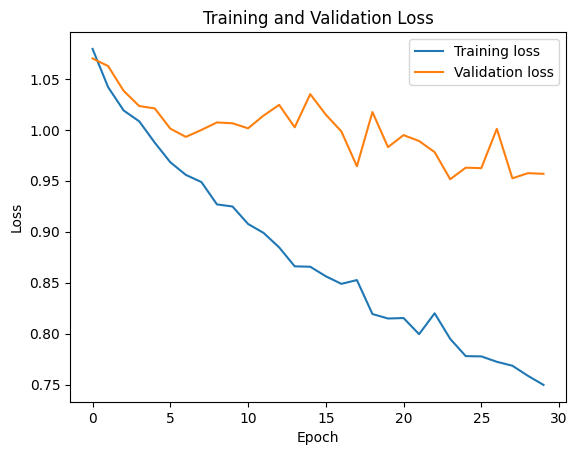

In [ ]:
import torch

# Instantiate the model
model = CNN3D15()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3) #lr=0.001

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []
valid_accuracy = []

# Load the training data if needed
model, optimizer, s_epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, '/content/checkpoint(12).pth')

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Validation loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == torch.argmax(target, dim=1)).sum().item()

accuracy = correct / total
print(f'Train Accuracy: {accuracy * 100:.2f}%')

Train Accuracy: 100.00%


In [ ]:
# _, _, e = load_checkpoint(model, optimizer, params_filename)

# 5-fold validation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN3D3(nn.Module):
    def __init__(self):
        super(CNN3D3, self).__init__()

        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm1 = nn.BatchNorm3d(8)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(32)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 24 * 24 * 20, 32)
        self.batch_norm_fc = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.fc2(x)

        return F.softmax(x, dim=1)

In [ ]:
import shutil
import os

In [ ]:
def save_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join('/content/drive/MyDrive/Checkpoints', filename))

def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch


In [ ]:
def train(train_loader, test_loader):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  # Instantiate the model
  model = CNN3D3()
  model.to(device)

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())

  # Initialize the loss arrays
  train_losses = []
  valid_losses = []
  valid_accuracy = []

  # Number of training epochs
  num_epochs = 25

  # Training loop
  for epoch in range(num_epochs):
      model.train()  # Set the model to training mode

      epoch_train_loss = 0

      for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()  # Zero the gradients

          # Forward pass
          output = model(data)

          # Calculate the loss
          loss = criterion(output, torch.argmax(target, dim=1))
          epoch_train_loss += loss.item()

          # Backward pass
          loss.backward()

          # Update weights
          optimizer.step()

          # Print training statistics
          # if batch_idx % 10 == 0:
          #     print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}')

      epoch_train_loss = epoch_train_loss / len(train_loader)

      # Validation loop
      model.eval()  # Set the model to evaluation mode
      correct = 0
      total = 0

      epoch_valid_loss = 0

      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              _, predicted = torch.max(output.data, 1)
              total += target.size(0)
              correct += (predicted == torch.argmax(target, dim=1)).sum().item()
              loss = criterion(output, torch.argmax(target, dim=1))
              epoch_valid_loss += loss.item()

      epoch_valid_loss = epoch_valid_loss / len(test_loader)

      accuracy = correct / total
      print(f'Validation Accuracy: {accuracy * 100:.2f}%')

      train_losses.append(epoch_train_loss)
      valid_losses.append(epoch_valid_loss)
      valid_accuracy.append(accuracy)

      # if epoch % 5 == 0:
      #     save_checkpoint(model, optimizer, epoch, params_filename)

  return train_losses, valid_losses, valid_accuracy

Fold 1/5
Validation Accuracy: 56.25%
Validation Accuracy: 56.25%
Validation Accuracy: 57.81%
Validation Accuracy: 62.50%
Validation Accuracy: 57.03%
Validation Accuracy: 64.06%
Validation Accuracy: 64.06%
Validation Accuracy: 71.09%
Validation Accuracy: 62.50%
Validation Accuracy: 72.66%
Validation Accuracy: 68.75%
Validation Accuracy: 78.91%
Validation Accuracy: 71.88%
Validation Accuracy: 73.44%
Validation Accuracy: 75.78%
Validation Accuracy: 72.66%
Validation Accuracy: 68.75%
Validation Accuracy: 78.12%
Validation Accuracy: 72.66%
Validation Accuracy: 71.88%
Validation Accuracy: 76.56%
Validation Accuracy: 75.78%
Validation Accuracy: 71.88%
Validation Accuracy: 65.62%
Validation Accuracy: 75.78%


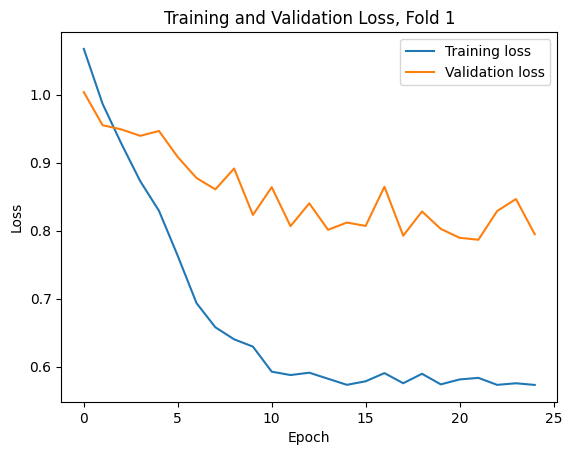

Fold 2/5
Validation Accuracy: 56.25%
Validation Accuracy: 56.25%
Validation Accuracy: 45.31%
Validation Accuracy: 55.47%
Validation Accuracy: 56.25%
Validation Accuracy: 61.72%
Validation Accuracy: 59.38%
Validation Accuracy: 72.66%
Validation Accuracy: 66.41%
Validation Accuracy: 64.84%
Validation Accuracy: 71.09%
Validation Accuracy: 67.19%
Validation Accuracy: 69.53%
Validation Accuracy: 73.44%
Validation Accuracy: 70.31%
Validation Accuracy: 70.31%
Validation Accuracy: 72.66%
Validation Accuracy: 71.09%
Validation Accuracy: 72.66%
Validation Accuracy: 70.31%
Validation Accuracy: 71.88%
Validation Accuracy: 71.88%
Validation Accuracy: 79.69%
Validation Accuracy: 69.53%
Validation Accuracy: 74.22%


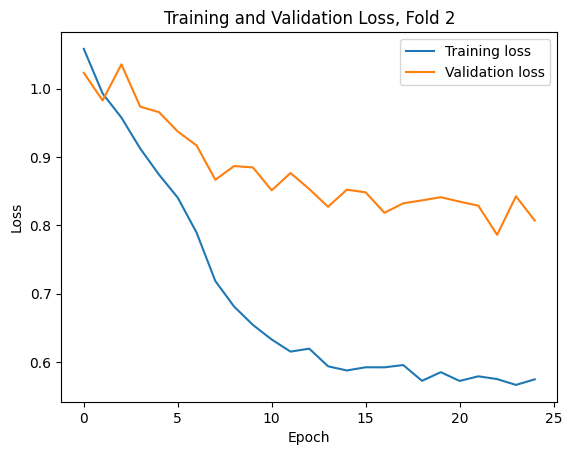

Fold 3/5
Validation Accuracy: 56.25%
Validation Accuracy: 57.81%
Validation Accuracy: 55.47%
Validation Accuracy: 55.47%
Validation Accuracy: 64.06%
Validation Accuracy: 65.62%
Validation Accuracy: 62.50%
Validation Accuracy: 72.66%
Validation Accuracy: 71.09%
Validation Accuracy: 70.31%
Validation Accuracy: 69.53%
Validation Accuracy: 75.00%
Validation Accuracy: 62.50%
Validation Accuracy: 75.00%
Validation Accuracy: 74.22%
Validation Accuracy: 78.12%
Validation Accuracy: 69.53%
Validation Accuracy: 70.31%
Validation Accuracy: 81.25%
Validation Accuracy: 76.56%


In [ ]:
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming 'X' is a list of file paths to your images and 'y' is your labels
X = images
y = labels

# Convert labels to one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = torch.nn.functional.one_hot(torch.tensor(y_encoded), num_classes=3).float()

# Create custom dataset
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        img_data = img_data / 6482.063678255918

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Define the number of splits for k-fold cross-validation
k = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store accuracies
accuracies = []
train_losses = []
valid_losses = []

# Iterate over each fold
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold_idx + 1}/{k}")

    # Split data into train and test sets
    X_train_fold, X_test_fold = np.array(X)[train_index], np.array(X)[test_index]
    y_train_fold, y_test_fold = y_one_hot[train_index], y_one_hot[test_index]

    # Create custom datasets
    train_dataset = CustomDataset(file_paths=X_train_fold, labels=y_train_fold)
    test_dataset = CustomDataset(file_paths=X_test_fold, labels=y_test_fold)

    # Create data loaders
    batch_size = 8
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Train and evaluate your model here
    train_loss, valid_loss, valid_accuracy = train(train_loader, test_loader)

    # Store accuracy for this fold
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    accuracies.append(valid_accuracy)


    # Plot training and validation loss
    plt.plot(train_loss, label='Training loss')
    plt.plot(valid_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss, Fold {fold_idx + 1}')
    plt.legend()
    plt.show()

# Calculate average accuracy across all folds
avg_accuracy = np.mean(accuracies)
print(f"Average accuracy: {avg_accuracy}")

#playground

In [ ]:
images[0]

'ADNI/002_S_0295/MPR__GradWarp__B1_Correction__N3__Scaled/2006-04-18_08_20_30.0/I45108/ADNI_002_S_0295_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070319113623975_S13408_I45108.nii'

In [ ]:
mkdir temp

In [ ]:
cp ADNI/${images[0]} ./temp/

In [ ]:
cd temp

/content/temp


In [ ]:
from PIL import Image
import tensorflow as tf

def load_file(filename):
  return tf.constant(np.array(Image.open(filename.numpy()).convert("L")))

ds = tf.data.Dataset.list_files("*.png")
ds_map = ds.map(lambda x: tf.py_function(load_file, [x], [tf.uint8]))

In [ ]:
list(iter(ds))[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'./Screenshot from 2024-01-30 21-01-55.png'>

In [ ]:
ds_map = ds.map(lambda x: tf.py_function(load_file, [x], [tf.uint8]))

In [ ]:
list(iter(ds_map))[0]

(<tf.Tensor: shape=(421, 1206), dtype=uint8, numpy=
 array([[ 4, 24, 24, ..., 31, 31, 31],
        [ 4, 24, 24, ..., 31, 31, 31],
        [ 4, 24, 24, ..., 31, 31, 31],
        ...,
        [24, 24, 24, ..., 31, 31, 31],
        [24, 24, 24, ..., 31, 31, 31],
        [24, 24, 24, ..., 31, 31, 31]], dtype=uint8)>,)

In [ ]:
bytes([68, 68, 69]).decode('utf-8')

'DDE'